# Quantum edge detection

Image processing allows us to understand what is occurring in an image, and edge detection is an essential method to identify components of an image. Edge detection is the process of detecting edges of components to distinguish them by their perimeter. In this tutorial, we will use Quantum Hadamard Edge detection (QHED) to perform edge detection [1](https://arxiv.org/pdf/2404.06889).

To perform quantum image processing on images used with classical image processing, we need to convert them to quantum images. There are various types of quantum image representation. In this tutorial, we will introduce the Quantum Probability Image Encoding (QPIE) and the Flexible Representation of Quantum Images (FRQI). 

In [12]:
import cudaq
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

cudaq.set_target("nvidia")

## Image 

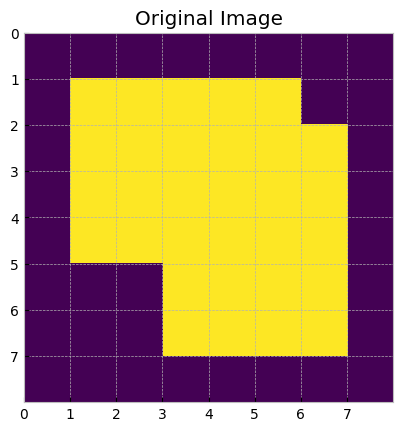

In [13]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

plot_image(image, 'Original Image')

## Quantum Probability Image Encoding (QPIE):

Lets take as an example a classical 2x2 image (4 pixels). We can label each pixel with its position

<div>
<img src="images/pixels-img.png" width="200">
</div>

Each pixel will have its own color intensity represented along with its position label as an 8-bit black and white color. To convert the pixel intensity to probability amplitudes of a quantum state

$$ c_i = \frac{I_{yx}}{\sqrt(\sum I^2_{yx})} $$

The state can now be written as:

$$ \ket{img} = c_0 \ket{00} + c_1 \ket{01} + c_2 \ket{10} + c_3 \ket{11}$$


### Below we show how to encode an image using QPIE in cudaq.



In [14]:
def amplitude_encode(img_data):
    # Convert the input data to a CuPy array
    img_data = cp.array(img_data)
    
    # Calculate the RMS value
    rms = cp.sqrt(cp.sum(cp.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = img_data / rms
    
    # Flatten the normalized image to a one-dimensional array
    image_norm_flat = image_norm.flatten()
    
    # Return the normalized image as a CuPy array with complex data type
    return image_norm_flat.astype(cp.complex64)

# Get the amplitude ancoded pixel values

# Horizontal: Original image
image_norm_h = amplitude_encode(image)
print('length of the horizontal state: ', image_norm_h.shape)
state_image_h = cudaq.State.from_data(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)
print('length of the vertical state: ', image_norm_v.shape)
state_image_v = cudaq.State.from_data(image_norm_v)

length of the horizontal state:  (64,)
length of the vertical state:  (64,)


## Flexible Representation of Quantum Images (FRQI):

Here, we encode the pixel data in angles, which requires only one qubit to store pixel information $\ket{c_i}$, and the rest of the qubits stores position $\ket{i}$ information. 

The gray value information of the pixels is encoded by
$$ \ket{c_i} =  \mathrm{cos}(\theta_i) \ket{0} + \mathrm{sin}(\theta_i) \ket{1} $$

where $\theta = (\theta_0, \theta_1, \theta_2, ...)$ is a vector of angles encoding the gray values of each pixel. The FRQI state is then given by

$$ \ket{img(\theta)} = \frac{1}{2^n} \sum_{i=0}^{2^{2n}-1}  \ket{c_i}  \ket{i}$$


To learn more about the FRQI representation, see [1](https://link.springer.com/article/10.1007/s11128-010-0177-y), [2](https://arxiv.org/pdf/2110.15672).

### Building the FRQI State:

In [15]:
def frqi(image):
    
    faltten_image = image.flatten()
    angles=[]
    for intensity in faltten_image:
        if intensity == 0:
            angles.append(0.0)
        else:
            theta = np.arcsin(intensity)
            angles.append(theta)

    # number of qubits
    pos_pixel = int(np.log2(len(angles)))

    k_value = pos_pixel-1

    # This function let us know which are the qubits that need to be applied  
    # the X-gate so we can change the state of the pixels positions qubits
    # to the new state.

    def change(state, new_state):
        
        n = len(state)  # n is the length of the binary string
        c = np.array([])  # create an empty array
        for i in range(n):  # start to iterate n times
            if state[i] != new_state[i]:               
                c = np.append(c, int(i))  # if it is different we append the position to the array
                
        if len(c) > 0:
            return c.astype(int)
        else:
            return c

    index=[]

    for jk in range(len(angles)):
        state = '{0:0{1}b}'.format(jk-1, pos_pixel)
        new_state = '{0:0{1}b}'.format(jk, pos_pixel)
        
        if jk != 0:
            c = change(state, new_state)
            if len(c) > 0:
                temp = np.abs(c-k_value)
                index.append(temp)

    index_q = []
    num_x = []

    for arr in index:
        count = 0
        arr = arr.tolist()
        for idx in arr:
            index_q.append(idx)
            count += 1
        num_x.append(count)
    
    return angles, index_q, num_x, pos_pixel

angles, index_q, num_x, pos_pixel = frqi(image)

print('Number of qubits:', pos_pixel)
print('Angles:', angles)
print('Length of angles:', len(angles))
#print('Index:', index_q)
#print('Number of X-gates:', num_x)

Number of qubits: 6
Angles: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Length of angles: 64


#### Measurement and Image Retrieval:

In [16]:
@cudaq.kernel
def y_rot(q:cudaq.qubit, theta:float):
    ry(2.0*theta, q)

@cudaq.kernel
def frqi(q_pos:int, angles:list[float], index_q:list[int], num_x:list[int]):
    qubits = cudaq.qvector(q_pos)
    aux = cudaq.qubit()
    
    h(qubits)
    
    j = 0
    count = 0
    for theta in angles:
        if j == 0:
            cudaq.control(y_rot, qubits, aux, theta)
        else:
            tot_x = num_x[j-1]
            for i in range(tot_x):
                x(qubits[index_q[count]])
                count += 1
            cudaq.control(y_rot, qubits, aux, theta)
        j += 1
    
    mz(qubits)
    mz(aux)
            
            
shots = 1000000    
counts = cudaq.sample(frqi, pos_pixel, angles, index_q, num_x, shots_count=shots)
#print(counts)

total_qubits = pos_pixel+1
amp = np.zeros(2**total_qubits)
for bit,count in counts.items():
    decimal = int(bit[::-1], 2)
    amp[decimal] = count/shots
    


In [17]:
# Create an empty array to save the retrieved image

retrieve_image = np.array([])

#print(retrieve_image.shape)

for i in range(len(angles)):
    s = format(i, '06b')
    #print(s)
    s_1 = '1' + s
    decimal_1 = int(s_1,2)
    s_0 = '0' + s
    decimal_0 = int(s_0, 2)
    
    pixel_value = np.arccos(np.sqrt(amp[decimal_0]/(amp[decimal_1]+amp[decimal_0])))
    
    if pixel_value > 0.0:
        retrieve_image = np.append(retrieve_image, pixel_value)
    else:
        retrieve_image = np.append(retrieve_image, [0.0])
    
#print(retrieve_image)
#print(retrieve_image.shape)

retrieve_image *= (2.0/np.pi)

# Turn the array into a type int
retrieve_image = retrieve_image.astype('int')

x = int(np.sqrt(len(angles)))
retrieve_image = retrieve_image.reshape((x,x))
print('retrieved image')
print(retrieve_image)

retrieved image
[[0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 0]
 [0 0 0 1 1 1 1 0]
 [0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0]]


## Quantum Hadamard Edge Detection (QHED)

Classically, to determine the edge of an image, we need to determine the pixel-intensity gradients. This requires processing each pixel, which leads to a complexity of O(N) for an image of N pixels. Since pixel number grows exponentially with image size, this poses a problem for large images.

With a quantum algorithm, we can determine the pixel-intensity gradients with complexity O(1), regardless of the image size, by taking advantage of the superposition induced by the Hadamard gate. This is an exponential speedup. Furthermore, we only need n qubits for an image with $2^n$ pixels.

Below, we show how to implement the QHED along with some classical post-processing to get our edge detected horizontal and vertical scans. We employ in this example QPIE to encode the image.

In [18]:
qubits_num= int(np.log2(image_norm_h.shape[0]))
total_qubits = qubits_num + 1

@cudaq.kernel
def qc_img(vec: cudaq.State):
    
    ancilla = cudaq.qubit()
    qubits = cudaq.qvector(vec)
    
    qubit_num = qubits.size()
    
    h(ancilla)

    x(ancilla)
    x.ctrl(ancilla, qubits[0])
    
    for i in range(1, qubit_num):
        x.ctrl([ancilla, *qubits[0:i]], qubits[i])
            
    h(ancilla)

print(cudaq.draw(qc_img, state_image_h))

     ╭───╮╭───╮                              ╭───╮
q0 : ┤ h ├┤ x ├──●────●────●────●────●────●──┤ h ├
     ╰───╯╰───╯╭─┴─╮  │    │    │    │    │  ╰───╯
q1 : ──────────┤ x ├──●────●────●────●────●───────
               ╰───╯╭─┴─╮  │    │    │    │       
q2 : ───────────────┤ x ├──●────●────●────●───────
                    ╰───╯╭─┴─╮  │    │    │       
q3 : ────────────────────┤ x ├──●────●────●───────
                         ╰───╯╭─┴─╮  │    │       
q4 : ─────────────────────────┤ x ├──●────●───────
                              ╰───╯╭─┴─╮  │       
q5 : ──────────────────────────────┤ x ├──●───────
                                   ╰───╯╭─┴─╮     
q6 : ───────────────────────────────────┤ x ├─────
                                        ╰───╯     



In [19]:
# Sampling the circuit

shots=100000
result_h = cudaq.sample(qc_img, state_image_h, shots_count=shots)
result_v = cudaq.sample(qc_img, state_image_v, shots_count=shots)

amp_h = np.zeros(2**total_qubits)

for bit,count in result_h.items():
    decimal = int(bit[::-1], 2)
    #print(decimal, bit, count/shots)
    amp_h[decimal] = count/shots

amp_v = np.zeros(2**total_qubits)

for bit,count in result_v.items():
    decimal = int(bit[::-1], 2)
    #print(decimal, bit, count/shots)
    amp_v[decimal] = count/shots    


### Post-processing 

In [20]:
x=int(np.sqrt(image_norm_h.shape[0]))
edge_scan_h = np.array([amp_h[2*i+1] for i in range(2**qubits_num)]).reshape(x, x)
edge_scan_v = np.array([amp_v[2*i+1] for i in range(2**qubits_num)]).reshape(x, x).T

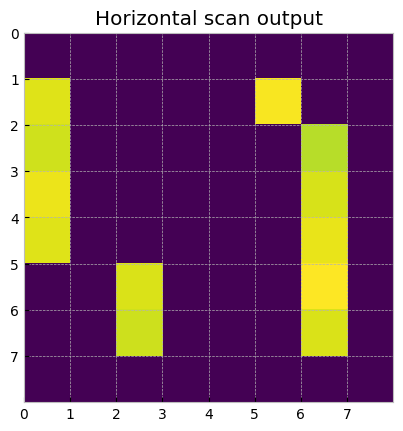

In [21]:
plot_image(edge_scan_h, 'Horizontal scan output')

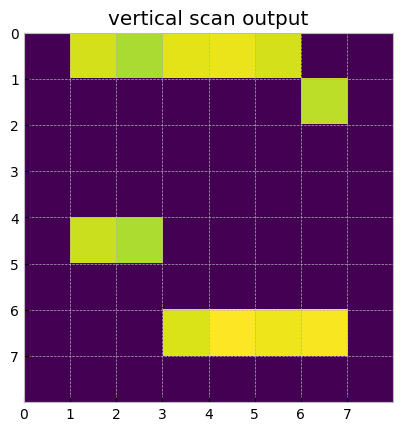

In [22]:
plot_image(edge_scan_v, 'vertical scan output')

Finally, we combine both horizontal and vertical scans to get the complete edge detected image

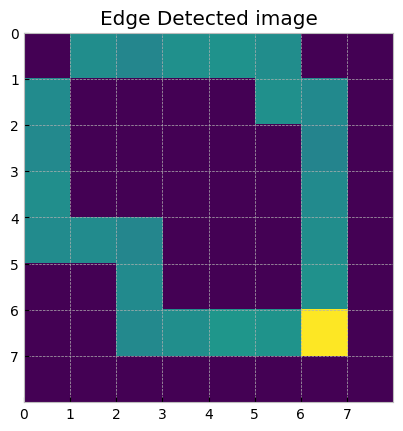

In [23]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h + edge_scan_v

plot_image(edge_scan_sim, 'Edge Detected image')